Toplam satır: 117
cycle_life NaN sayısı: 0

Kullanılacak feature sayısı: 24
['Qd_mean', 'Qd_std', 'IR_mean', 'IR_std', 'Tavg_mean', 'dQd_slope', 'dqdv_peak_first', 'dqdv_peak_last', 'dqdv_peak_delta', 'dqdv_peak_mean', 'dqdv_peak_std', 'dqdv_peak_slope', 'dqdv_area_first', 'dqdv_area_last', 'dqdv_area_delta', 'dqdv_area_mean', 'dqdv_area_std', 'dqdv_area_slope', 'dqdv_peakpos_first', 'dqdv_peakpos_last', 'dqdv_peakpos_delta', 'dqdv_peakpos_mean', 'dqdv_peakpos_std', 'dqdv_peakpos_slope']
Temizlik sonrası satır sayısı: 117

n_cycles = 100 için satır sayısı: 39

=== RF Conformal (n_cycles=100) ===
MAE: 119.82, R²: 0.3202
q_alpha: 197.23, coverage: 75.0%

=== XGBoost Conformal (n_cycles=100) ===
MAE: 74.23, R²: 0.7602
q_alpha: 82.39, coverage: 62.5%


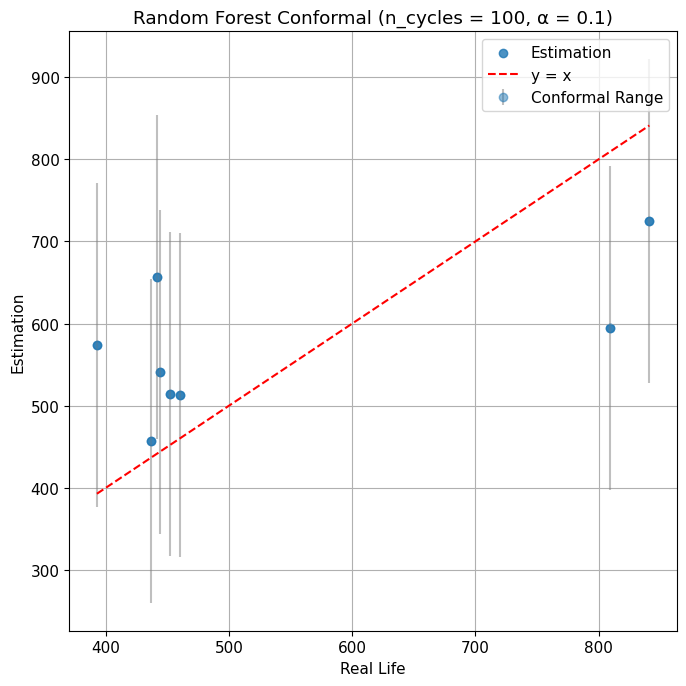

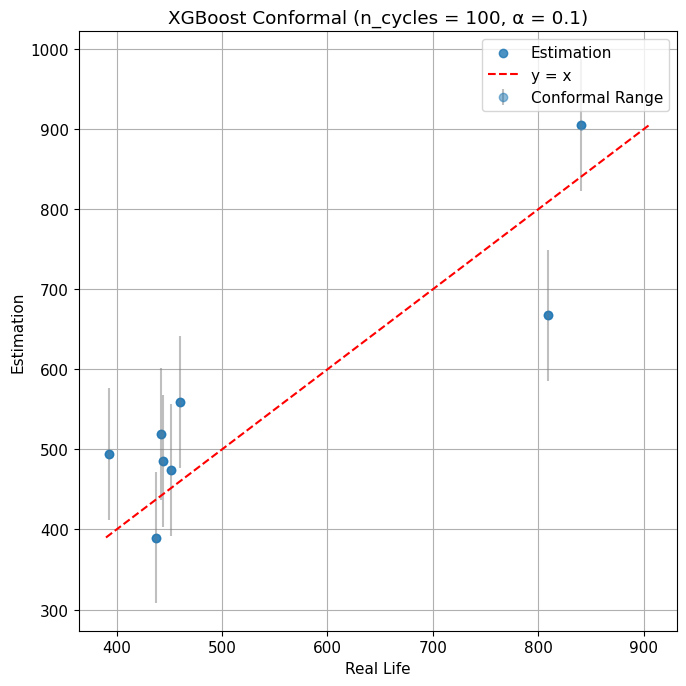

In [4]:
# ============================================================
# Conformal Prediction — Random Forest & XGBoost
# Tüm feature seti + n_cycles = 100 için
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

plt.rcParams["figure.figsize"] = (7, 7)
plt.rcParams["font.size"] = 11

# ------------------------------------------------------------
# 1) Veriyi yükle ve hedefi temizle
# ------------------------------------------------------------
df = pd.read_csv("../features_early_cycles.csv")
print("Toplam satır:", len(df))

df = df.copy()
df["cycle_life"] = (
    df["cycle_life"]
    .astype(str)
    .str.strip()
    .str.replace(r"[\[\]]", "", regex=True)
)
df["cycle_life"] = pd.to_numeric(df["cycle_life"], errors="coerce")
print("cycle_life NaN sayısı:", df["cycle_life"].isna().sum())

# ------------------------------------------------------------
# 2) Tüm feature seti (olan kolonları otomatik seçiyoruz)
# ------------------------------------------------------------
candidate_features = [
    # Özet feature'lar
    "Qd_mean", "Qd_std",
    "IR_mean", "IR_std",
    "Tavg_mean",
    "dQd_slope",

    # dQ/dV peak
    "dqdv_peak_first", "dqdv_peak_last", "dqdv_peak_delta",
    "dqdv_peak_mean", "dqdv_peak_std", "dqdv_peak_slope",

    # dQ/dV area
    "dqdv_area_first", "dqdv_area_last", "dqdv_area_delta",
    "dqdv_area_mean", "dqdv_area_std", "dqdv_area_slope",

    # varsa peak position
    "dqdv_peakpos_first", "dqdv_peakpos_last", "dqdv_peakpos_delta",
    "dqdv_peakpos_mean", "dqdv_peakpos_std", "dqdv_peakpos_slope",

    # varsa variance
    "dqdv_var_first", "dqdv_var_last", "dqdv_var_delta",
    "dqdv_var_mean", "dqdv_var_std", "dqdv_var_slope",

    # capacity fade slope
    "Qd_slope", "Qd_intercept", "Qd_first", "Qd_last", "Qd_delta",
]

feature_cols = [c for c in candidate_features if c in df.columns]
print("\nKullanılacak feature sayısı:", len(feature_cols))
print(feature_cols)

df = df.dropna(subset=["cycle_life"] + feature_cols)
print("Temizlik sonrası satır sayısı:", len(df))

# ------------------------------------------------------------
# 3) Sadece n_cycles = 100 için veri seç (istersen 50/25'e de uygularız)
# ------------------------------------------------------------
N_CYCLES = 100

df_sub = df[df["n_cycles"] == N_CYCLES].copy()
print(f"\nn_cycles = {N_CYCLES} için satır sayısı:", len(df_sub))

X = df_sub[feature_cols].values
y = df_sub["cycle_life"].values

# ------------------------------------------------------------
# 4) Split Conformal Prediction fonksiyonu (genel)
# ------------------------------------------------------------
def split_conformal_regression(X, y, model_cls, model_params, alpha=0.1):
    """
    Split Conformal Prediction (regresyon)
    - X, y: tüm veri
    - model_cls: RandomForestRegressor veya XGBRegressor
    - model_params: model parametreleri dict
    - alpha = 0.1 -> %90 güven aralığı
    """
    # 1) Önce test seti ayır (örneğin %20)
    X_train_cal, X_test, y_train_cal, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # 2) Train ve calibration setlerine böl (örneğin %70 train, %30 cal)
    X_train, X_cal, y_train, y_cal = train_test_split(
        X_train_cal, y_train_cal, test_size=0.3, random_state=42
    )

    # 3) Modeli train set üzerinde eğit
    model = model_cls(**model_params)
    model.fit(X_train, y_train)

    # 4) Calibration set üzerinde artıklar (residual) hesapla
    y_cal_pred = model.predict(X_cal)
    residuals = np.abs(y_cal - y_cal_pred)

    # 5) Quantile değeri → interval yarıçapı
    q_alpha = np.quantile(residuals, 1 - alpha)

    # 6) Test set üzerinde tahmin ve interval
    y_test_pred = model.predict(X_test)
    lower = y_test_pred - q_alpha
    upper = y_test_pred + q_alpha

    # 7) Noktasal performans (conformal öncesi)
    mae = mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)

    # 8) Kapsama oranı (coverage) — kaç gerçek değer aralık içinde?
    covered = ((y_test >= lower) & (y_test <= upper)).mean()

    return {
        "model": model,
        "mae": mae,
        "r2": r2,
        "q_alpha": q_alpha,
        "coverage": covered,
        "y_test": y_test,
        "y_pred": y_test_pred,
        "lower": lower,
        "upper": upper,
    }

# ------------------------------------------------------------
# 5) RF ve XGB için ayrı parametreler
# ------------------------------------------------------------
rf_params = {
    "n_estimators": 400,
    "min_samples_leaf": 2,
    "max_features": "sqrt",
    "random_state": 42,
    "n_jobs": -1,
}

xgb_params = {
    "n_estimators": 800,
    "learning_rate": 0.03,
    "max_depth": 6,
    "subsample": 0.80,
    "colsample_bytree": 0.80,
    "reg_lambda": 2.0,
    "reg_alpha": 1.0,
    "random_state": 42,
    "n_jobs": -1,
    "tree_method": "hist",
}

alpha = 0.1  # %90 güven aralığı

rf_res  = split_conformal_regression(X, y, RandomForestRegressor, rf_params, alpha)
xgb_res = split_conformal_regression(X, y, XGBRegressor,         xgb_params, alpha)

print(f"\n=== RF Conformal (n_cycles={N_CYCLES}) ===")
print(f"MAE: {rf_res['mae']:.2f}, R²: {rf_res['r2']:.4f}")
print(f"q_alpha: {rf_res['q_alpha']:.2f}, coverage: {rf_res['coverage']*100:.1f}%")

print(f"\n=== XGBoost Conformal (n_cycles={N_CYCLES}) ===")
print(f"MAE: {xgb_res['mae']:.2f}, R²: {xgb_res['r2']:.4f}")
print(f"q_alpha: {xgb_res['q_alpha']:.2f}, coverage: {xgb_res['coverage']*100:.1f}%")

# ------------------------------------------------------------
# 6) Grafik: RF ve XGB için ayrı ayrı conformal aralıkları
# ------------------------------------------------------------
def plot_conformal(res, title):
    y_test = res["y_test"]
    y_pred = res["y_pred"]
    lower  = res["lower"]
    upper  = res["upper"]

    plt.figure()
    plt.scatter(y_test, y_pred, label="Estimation", alpha=0.8)
    plt.errorbar(
        y_test, y_pred,
        yerr=[y_pred - lower, upper - y_pred],
        fmt='o', ecolor='gray', alpha=0.5, label="Conformal Range"
    )

    mn, mx = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
    plt.plot([mn, mx], [mn, mx], 'r--', label="y = x")

    plt.xlabel("Real Life")
    plt.ylabel("Estimation")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_conformal(rf_res,  f"Random Forest Conformal (n_cycles = {N_CYCLES}, α = {alpha})")
plot_conformal(xgb_res, f"XGBoost Conformal (n_cycles = {N_CYCLES}, α = {alpha})")
